In [1]:
import boto3
import cufflinks as cf
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import warnings

from io import StringIO
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
cf.go_offline()
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [3]:
def get_secret():
    secret_name = "s3_data_analysis"
    region_name = "us-east-1"

    # Create a Secrets Manager client with default credentials
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        # Retrieve the secret value from Secrets Manager
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    # Extract the secret string (which is a JSON object)
    secret = get_secret_value_response['SecretString']
    
    # Parse the secret string as JSON
    secrets = json.loads(secret)
    
    # Retrieve AWS credentials from the secrets
    aws_access_key_id = secrets['aws_access_key_id']
    aws_secret_access_key = secrets['aws_secret_access_key']
    
    # Now use the retrieved credentials to create the S3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )

    return s3_client

s3_client = get_secret()

In [4]:
def read_csv_from_s3(bucket_name, key, s3_client=None):
    
    if s3_client is None:
        s3_client = boto3.client('s3')
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        data = StringIO(csv_content)
        df = pd.read_csv(data)
        return df
    except Exception as e:
         print(f"Error reading CSV from S3: {e}")
         return None

bucket_name = 'nk.data.analysis'
key = 'Bitcoin_Analysis/btcusd_1-min_data.csv'

df = read_csv_from_s3(bucket_name, key, s3_client)

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

df = df.sort_index(ascending=False).reset_index()

df.drop('index', axis=1, inplace=True)

df.set_index('Timestamp', inplace=True)

In [6]:
df_daily = df.resample('D').agg({
    'Open': 'first',    # First entry of each day
    'High': 'max',      # Highest value for each day
    'Low': 'min',       # Lowest value for each day
    'Close': 'last',    # Last entry of each day
    'Volume': 'sum'     # Summing the volume for each day (optional)
}).dropna()

df_daily = df_daily.sort_index(ascending=False)

bitcoin_sample = df_daily[0:50]

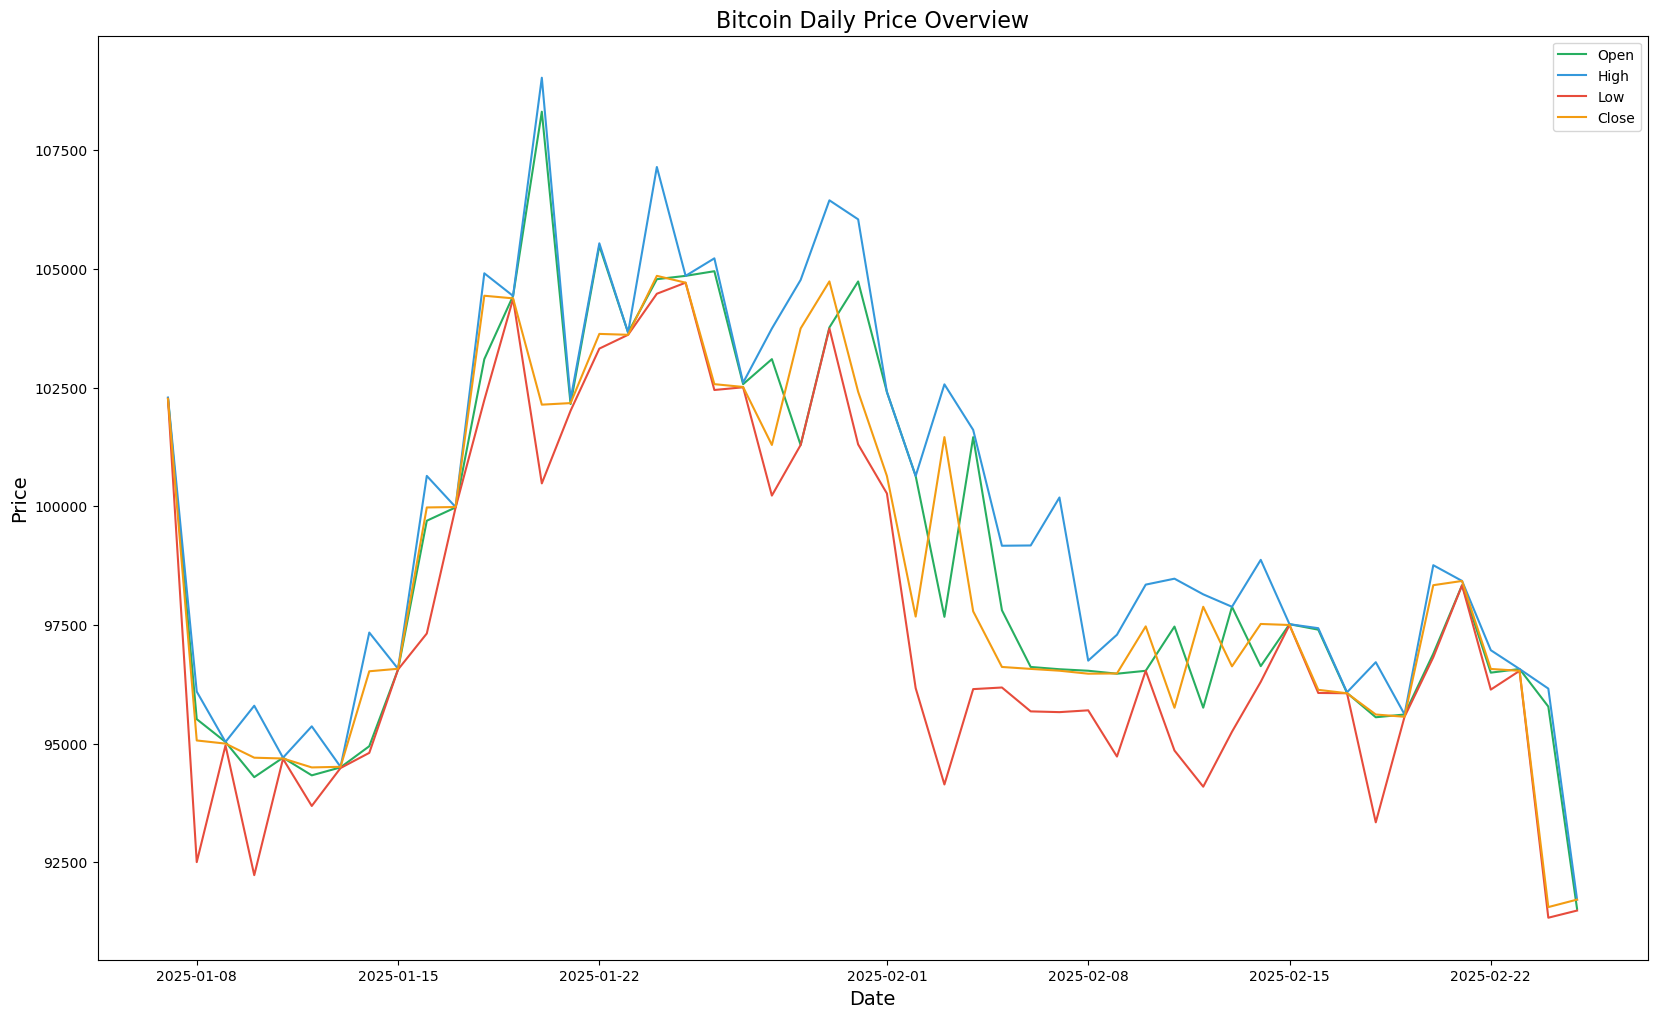

In [7]:
plt.figure(figsize=(20,12))

colors = {
    'Open': '#27AE60',    # Emerald Green
    'High': '#3498DB',    # Steel Blue
    'Low': '#E74C3C',     # Crimson Red
    'Close': '#F39C12'    # Bitcoin Gold/Orange
}


for col in ['Open', 'High', 'Low', 'Close']:
    plt.plot(bitcoin_sample.index, bitcoin_sample[col], label=col, color=colors[col])

plt.title('Bitcoin Daily Price Overview', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

plt.legend()

plt.show()

In [8]:
trace = go.Candlestick(
    x=bitcoin_sample.index,
    high=bitcoin_sample['High'],
    low=bitcoin_sample['Low'],
    open=bitcoin_sample['Open'],
    close=bitcoin_sample['Close'],
    increasing_line=dict(color='#27AE60', width=2),
    decreasing_line=dict(color='#E74C3C', width=2)
)

fig = go.Figure(data=[trace])

fig.update_layout(
    title='Bitcoin Historical Prices',
    xaxis=dict(
        title='Date',
        tickformat='%b %d, %Y',
        tickangle=-45
    ),
    yaxis=dict(
        title='Price',
        gridcolor='lightgray',
        zerolinecolor='black'
    ),
    hovermode='x unified',
    xaxis_rangeslider_visible=False
)

fig.show()



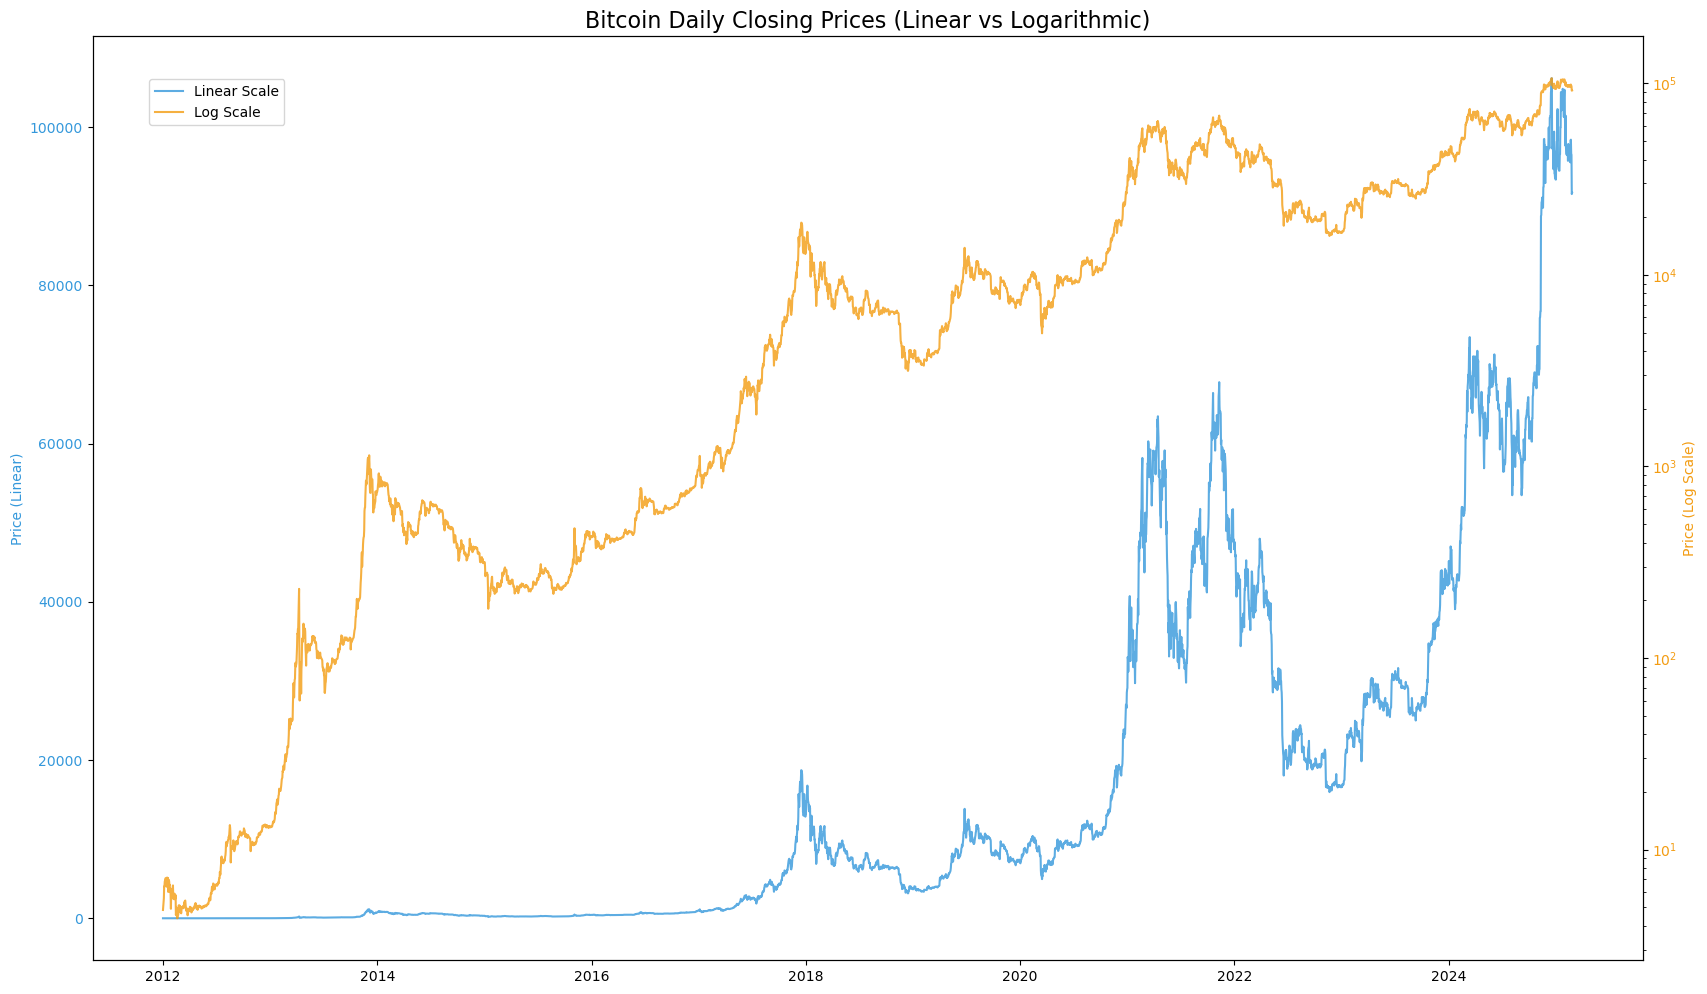

In [9]:
fig, ax1 = plt.subplots(figsize=(20, 12))

# Plot the original closing prices on the primary y-axis (linear scale)
ax1.plot(df_daily.index, df_daily['Close'], label="Linear Scale", color="#3498DB", alpha=0.8)
ax1.set_ylabel("Price (Linear)", color="#3498DB")
ax1.tick_params(axis='y', labelcolor="#3498DB")
ax1.set_yscale("linear")

# Create a secondary y-axis (logarithmic scale)
ax2 = ax1.twinx()
ax2.plot(df_daily.index, df_daily['Close'], label="Log Scale", color="#F39C12", alpha=0.8)
ax2.set_ylabel("Price (Log Scale)", color="#F39C12")
ax2.tick_params(axis='y', labelcolor="#F39C12")
ax2.set_yscale("log")

# Title and legend
plt.title("Bitcoin Daily Closing Prices (Linear vs Logarithmic)", fontsize=16)
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))  # Adjust legend placement

plt.show()

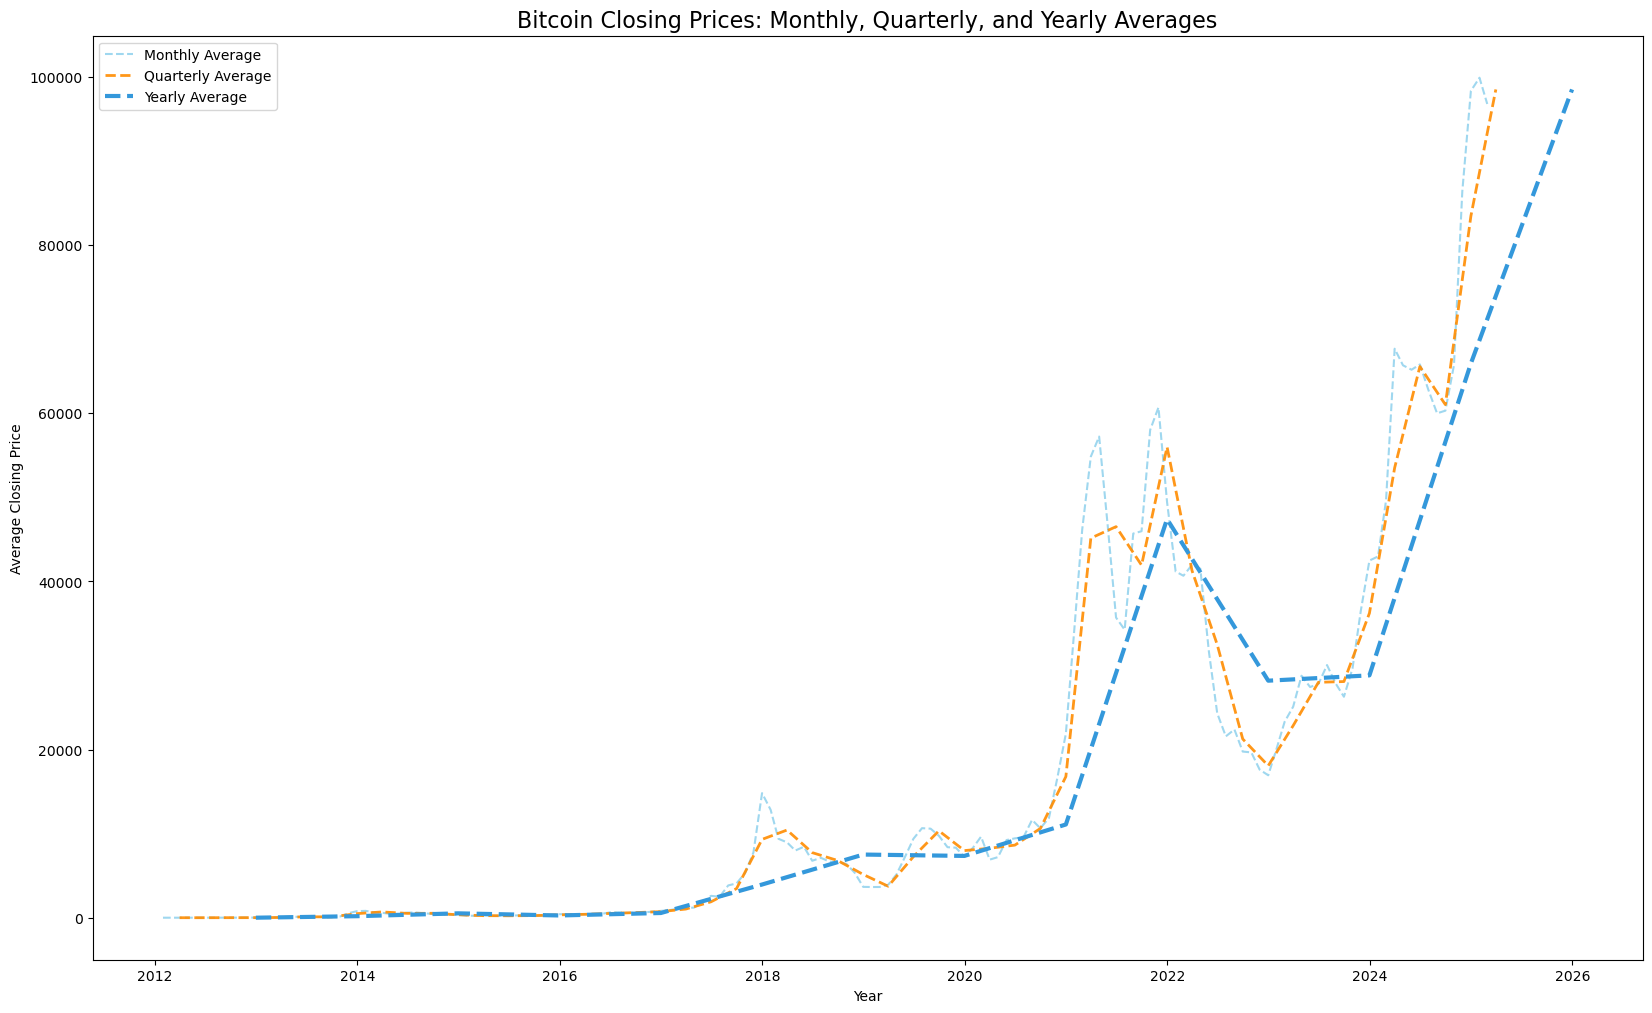

In [10]:
plt.figure(figsize=(20, 12))

plt.plot(df_daily['Close'].resample('M').mean(), 
         label="Monthly Average", 
         color="skyblue", 
         linestyle="--", 
         linewidth=1.5, 
         alpha=0.8)

plt.plot(df_daily['Close'].resample('Q').mean(), 
         label="Quarterly Average", 
         color="darkorange", 
         linestyle="--", 
         linewidth=2, 
         alpha=0.9)

plt.plot(df_daily['Close'].resample('Y').mean(), 
         label="Yearly Average", 
         color="#3498DB", 
         linestyle="--", 
         linewidth=3, 
         alpha=1)

plt.title("Bitcoin Closing Prices: Monthly, Quarterly, and Yearly Averages", fontsize=16)
plt.ylabel("Average Closing Price")
plt.xlabel("Year")
plt.legend()

plt.show()

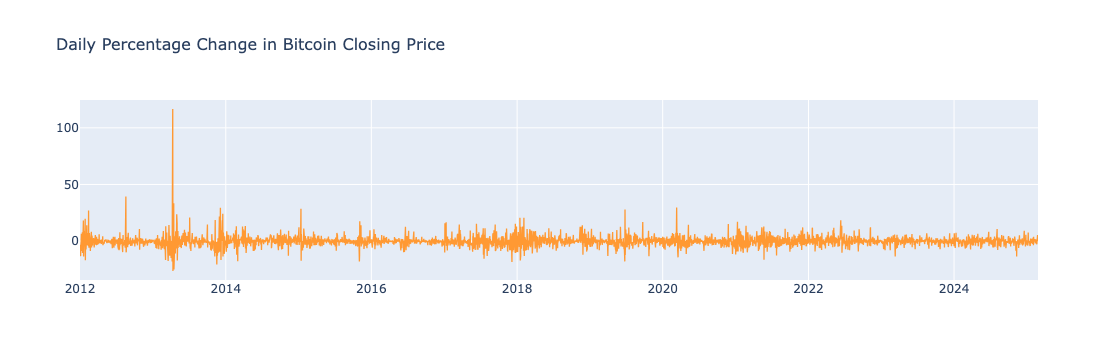

In [11]:
df_daily['close_price_pct_change'] = df_daily['Close'].pct_change()*100

df_daily['close_price_pct_change'].iplot(
    layout=dict(
        title='Daily Percentage Change in Bitcoin Closing Price',
        autosize=True,
        titlefont=dict(size=16),
    )
)
